In [1]:
import pandas as pd 
import re
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [2]:
data = pd.read_excel("./data/data1.xlsx")

In [3]:
data.head()

,study_hours,final_grade,explanation_quality,absences,group_work,exam_content,schedule,class_participation,result
0,33.0,16.32,7,<25%,oui,mélange,matin,un petit peu,valide apres rattrapage
1,26.6,16.00,7,<25%,oui,fait parti du cours enseigner par le prof,soir,un petit peu,valide apres rattrapage
2,34.5,17.88,6,<25%,oui,mélange,soir,un petit peu,valide apres rattrapage
3,43.2,20.00,4,<50%,non,mélange,soir,moyen,valide apres rattrapage
4,25.7,13.25,5,<25%,oui,mélange,matin,moyen,valide apres rattrapage


In [4]:
data.describe()

,study_hours,final_grade,explanation_quality
count,4872.000000,4872.000000,4872.000000
mean,28.002709,15.785437,5.996305
std,9.820886,3.606864,1.964891
min,0.000000,5.000000,1.000000
25%,21.400000,13.270000,5.000000
50%,28.100000,16.285000,6.000000
75%,34.625000,19.150000,7.000000
max,50.000000,20.000000,10.000000


In [5]:
data.isnull().sum()

study_hours            0
final_grade            0
explanation_quality    0
absences               0
group_work             0
exam_content           0
schedule               0
class_participation    0
result                 0
dtype: int64

# EDA

In [6]:
# How many rows and columns
data.shape

(4872, 9)

In [7]:
# Quick look at the first few rows
data.head()

,study_hours,final_grade,explanation_quality,absences,group_work,exam_content,schedule,class_participation,result
0,33.0,16.32,7,<25%,oui,mélange,matin,un petit peu,valide apres rattrapage
1,26.6,16.00,7,<25%,oui,fait parti du cours enseigner par le prof,soir,un petit peu,valide apres rattrapage
2,34.5,17.88,6,<25%,oui,mélange,soir,un petit peu,valide apres rattrapage
3,43.2,20.00,4,<50%,non,mélange,soir,moyen,valide apres rattrapage
4,25.7,13.25,5,<25%,oui,mélange,matin,moyen,valide apres rattrapage


In [8]:
# Detailed info about types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4872 entries, 0 to 4871
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   study_hours          4872 non-null   float64
 1   final_grade          4872 non-null   float64
 2   explanation_quality  4872 non-null   int64  
 3   absences             4872 non-null   object 
 4   group_work           4872 non-null   object 
 5   exam_content         4872 non-null   object 
 6   schedule             4872 non-null   object 
 7   class_participation  4872 non-null   object 
 8   result               4872 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 342.7+ KB


In [9]:
print(data['study_hours'].isna().sum())

0


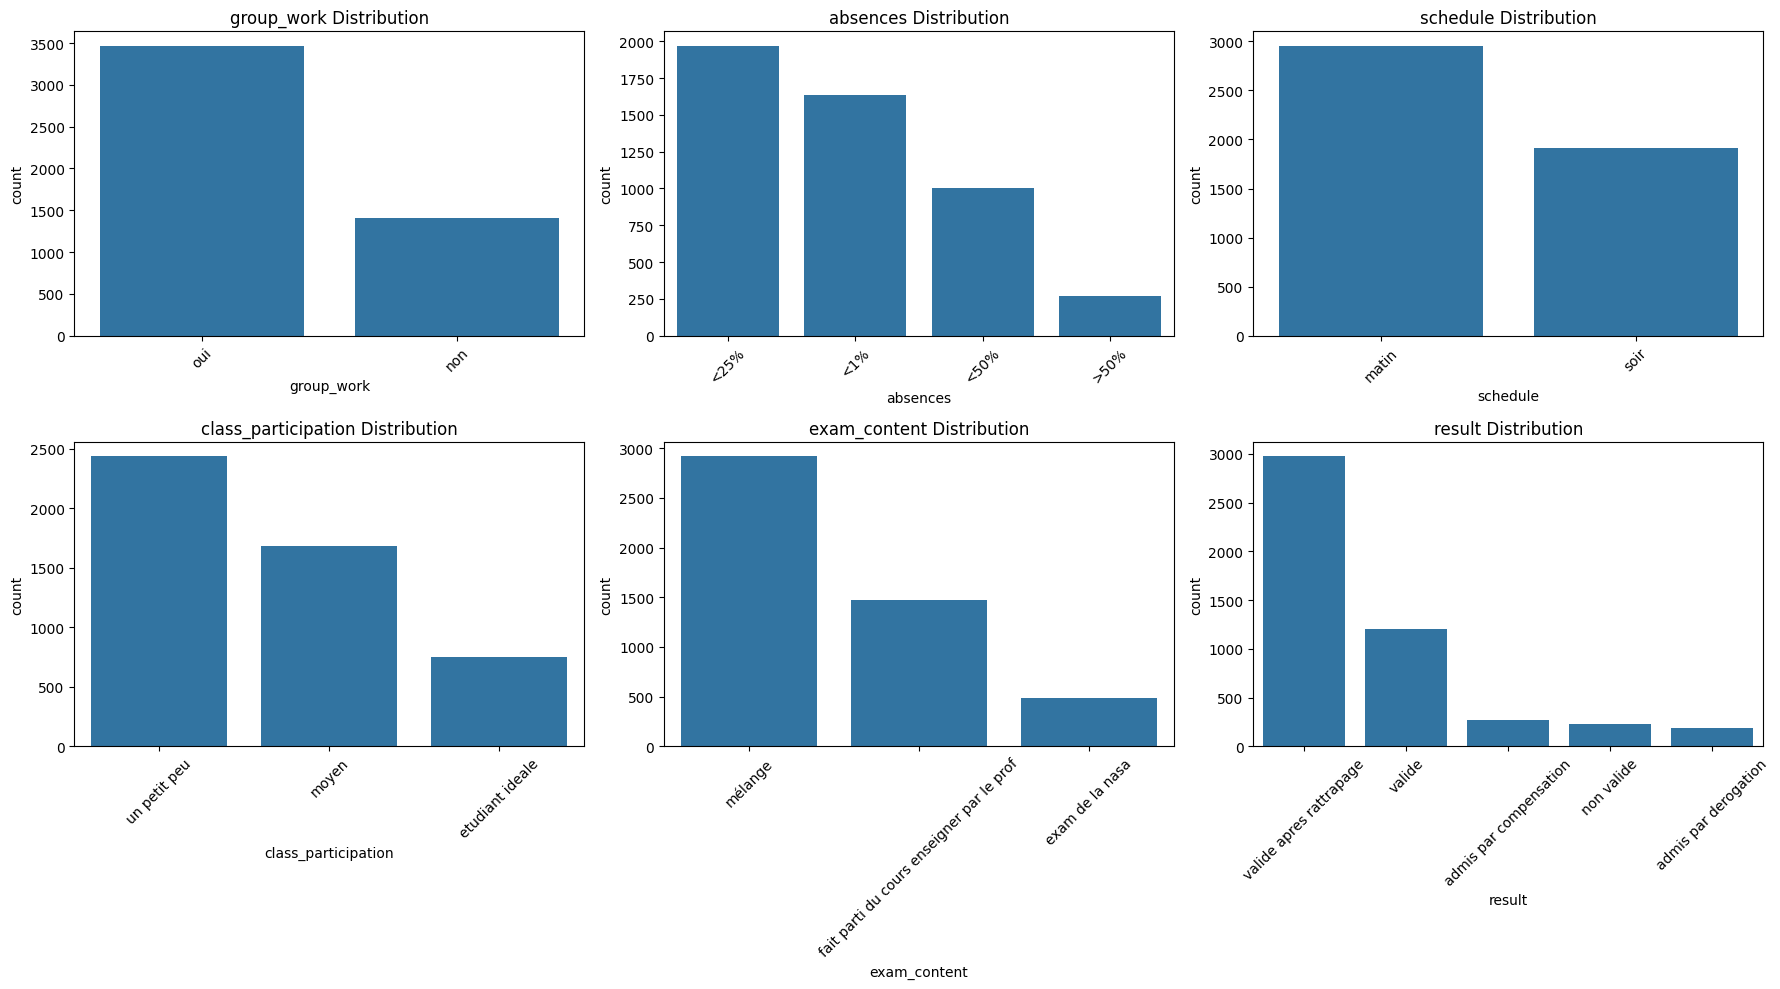

In [10]:
# List of your categorical columns
categorical_cols = ['group_work', 'absences', 'schedule', 'class_participation', 'exam_content', 'result']

# Create subplots
plt.figure(figsize=(18, 10))  # Big figure for multiple plots

for idx, col in enumerate(categorical_cols):
    plt.subplot(2, 3, idx + 1)  # 2 rows, 3 columns, plot number idx+1
    sns.countplot(x=col, data=data, order=data[col].value_counts().index)
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Interpretation of Categorical Feature Distributions

## 1. `group_work` Distribution

- "Non" (no group work) is more frequent than "oui" (yes group work).
- Students who did **not participate in group work** are slightly more common.
- ➔ This could mean that **group work is optional** or that **many students prefer to study individually**.
- ➔ Important later to check if group work participation impacts results.

## 2. `absences` Distribution

- `<1%` absence dominates, followed by `<25%`, `<50%`, and `>50%`.
- Most students **have very low absence rates** (good attendance).
- ➔ Attendance seems generally **good** across the dataset.
- ➔ Important: students with high absences (`>50%`) might have lower final results — to verify later.

## 3. `schedule` Distribution

- "matin" (morning classes) are much more common than "soir" (evening classes).
- Majority of the courses happen **in the morning**.
- ➔ Maybe evening students are special cases (working students?), could affect performance — needs checking.

## 4. `class_participation` Distribution

- "un petit peu" (a little participation) is the most common, followed by "moyen" (average participation), and fewer "étudiant idéal" (ideal students).
- ➔ Most students **only participate a little** in class.
- ➔ Very **few are model students** ("étudiant idéal").
- ➔ Important: more participation might correlate with better results — to check later.

## 5. `exam_content` Distribution

- "fait parti du cours enseigner par le prof" dominates heavily, "mélange" and "exam de la nasa" are less frequent.
- Most exams **are directly based on course material taught**.
- ➔ Some exams ("mélange" or "exam de la nasa") may be harder or unexpected — worth checking if those students performed differently.

## 6. `result` (Target) Distribution

- "valide" is extremely dominant, while "valide après rattrapage", "admis par compensation" are fewer, and "non valide" and "admis par dérogation" are very rare.
- ➔ **Most students pass** their courses normally.
- ➔ Very few fail completely (`non valide`) or pass exceptionally (`dérogation`).
- ➔ The dataset is **imbalanced** toward positive results → class imbalance techniques might be necessary during modeling.


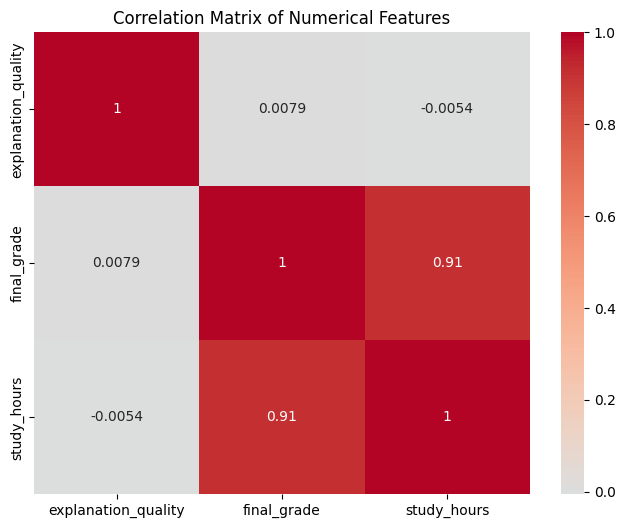

In [11]:
# Select only numerical columns
numerical_cols = ['explanation_quality', 'final_grade', 'study_hours']

# Compute the correlation matrix
corr = data[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

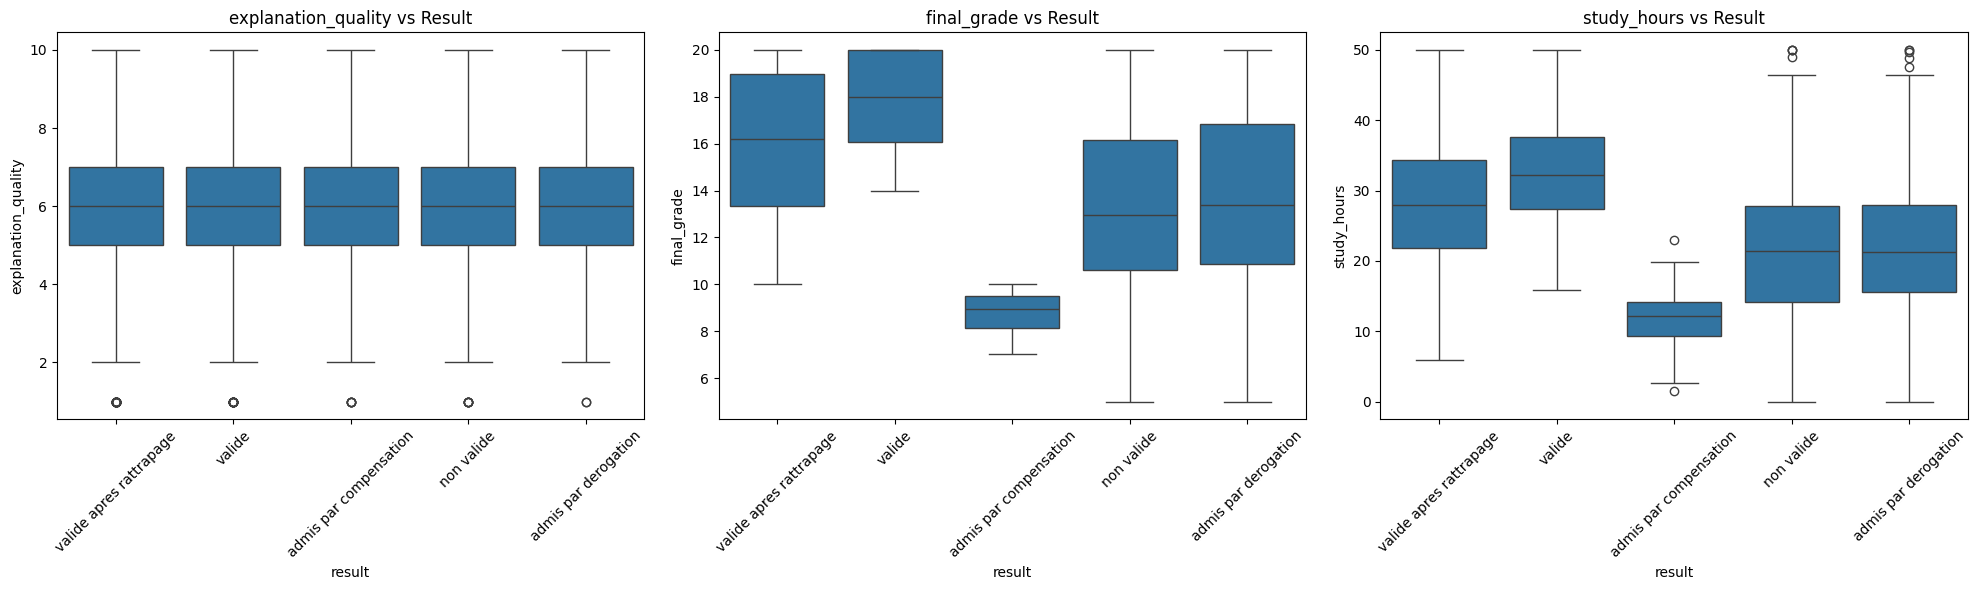

In [12]:
# List of numerical columns
numerical_cols = ['explanation_quality', 'final_grade', 'study_hours']

# Create boxplots for each numerical feature against 'result'
plt.figure(figsize=(20,6))

for idx, col in enumerate(numerical_cols):
    plt.subplot(1, 3, idx + 1)  # 1 row, 3 columns
    sns.boxplot(x='result', y=col, data=data)
    plt.title(f"{col} vs Result")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

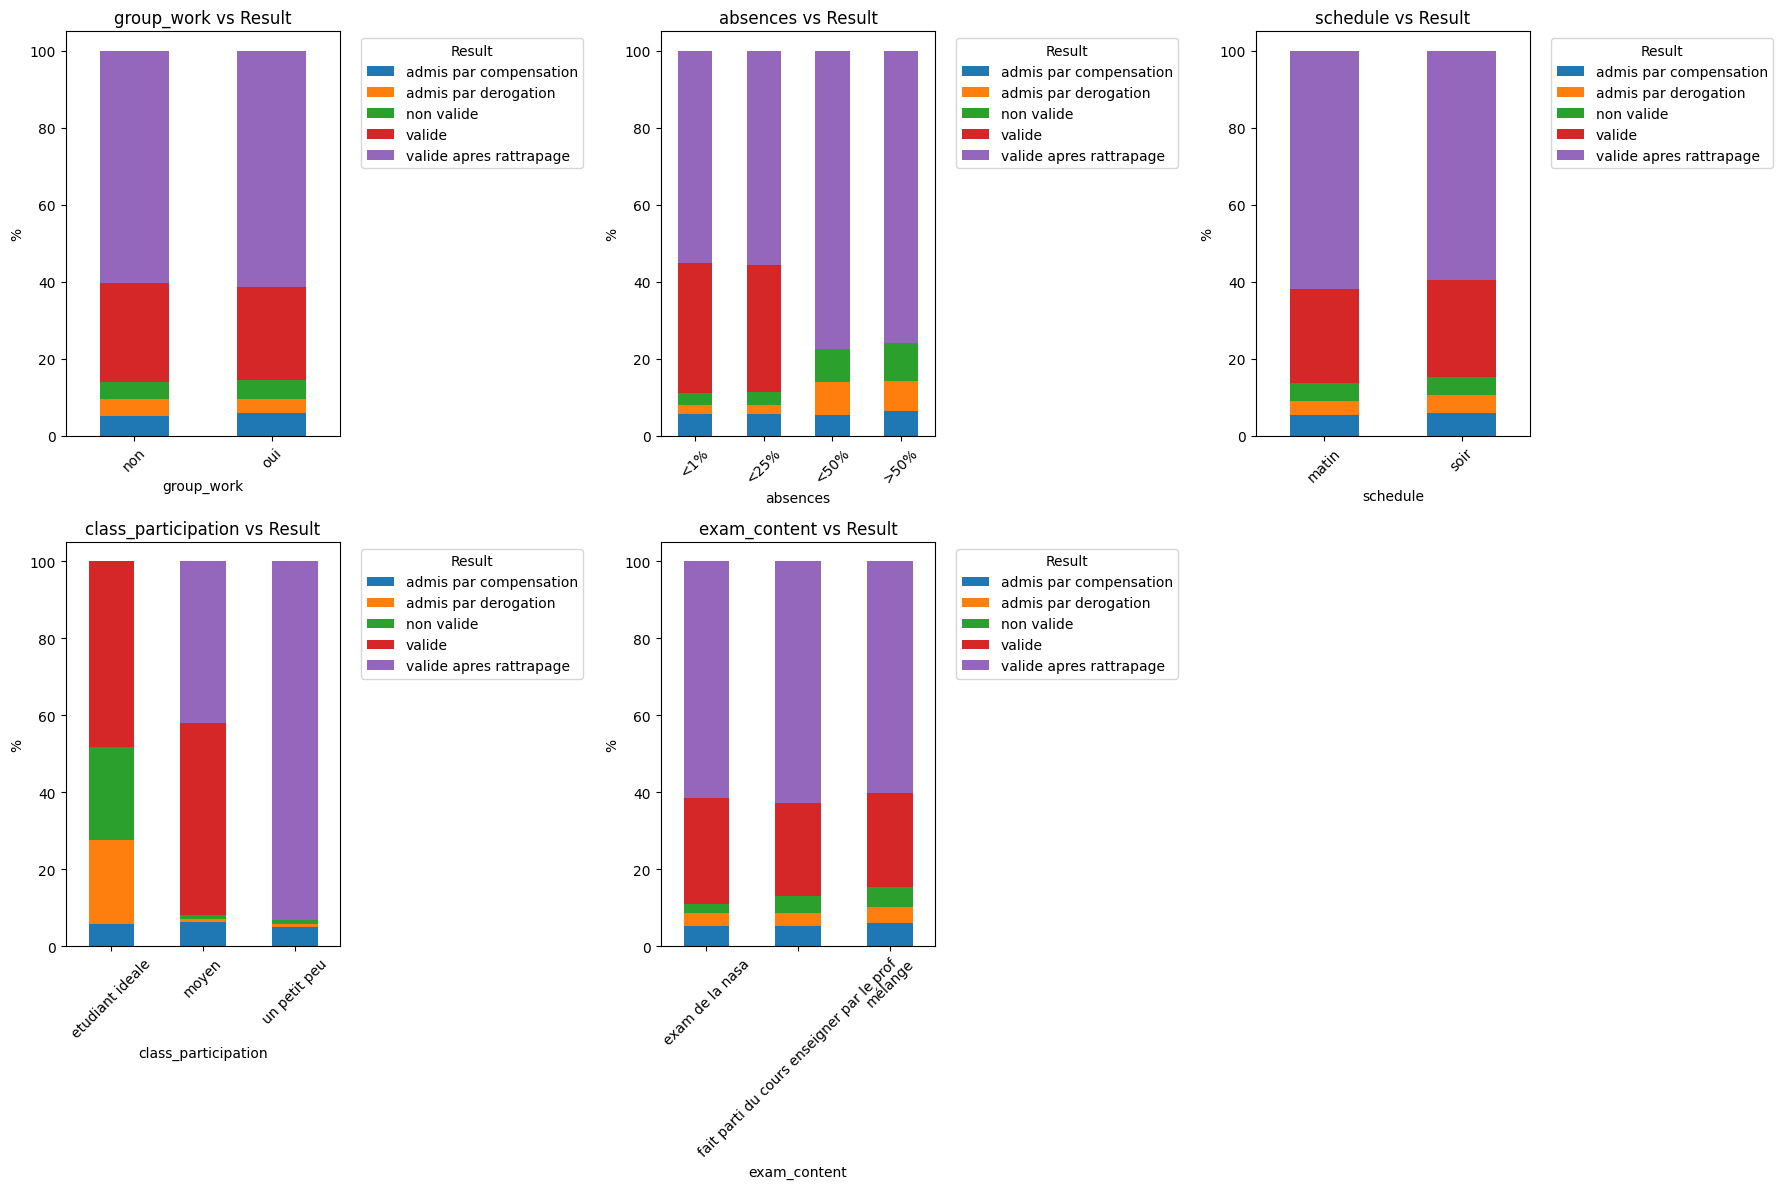

In [13]:
# List of categorical features
categorical_cols = ['group_work', 'absences', 'schedule', 'class_participation', 'exam_content']

# Create subplots
plt.figure(figsize=(18, 12))

for idx, col in enumerate(categorical_cols):
    plt.subplot(2, 3, idx + 1)  # 2 rows, 3 columns
    crosstab = pd.crosstab(data[col], data['result'], normalize='index') * 100
    crosstab.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title(f"{col} vs Result")
    plt.ylabel('%')
    plt.xticks(rotation=45)
    plt.legend(title='Result', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

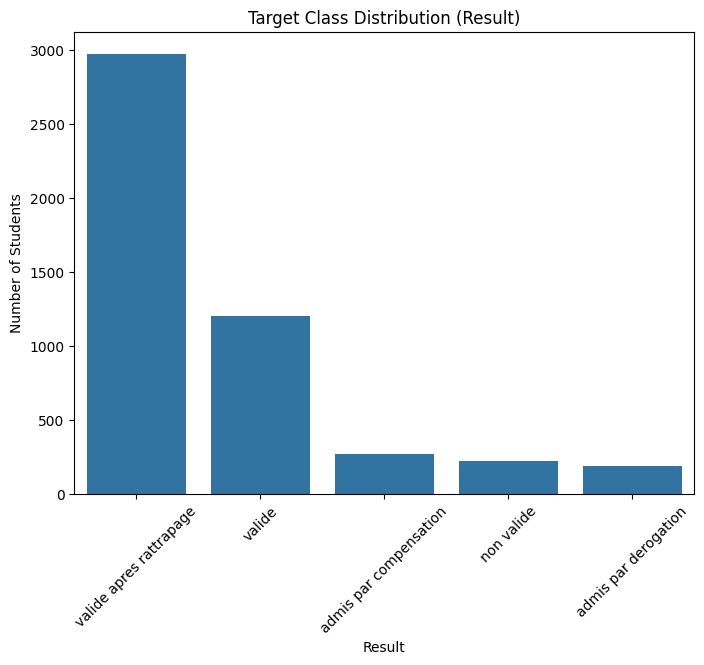

result
valide apres rattrapage    61.042693
valide                     24.733169
admis par compensation      5.623974
non valide                  4.659278
admis par derogation        3.940887
Name: proportion, dtype: float64


In [14]:

# Countplot of result
plt.figure(figsize=(8,6))
sns.countplot(x='result', data=data, order=data['result'].value_counts().index)
plt.title('Target Class Distribution (Result)')
plt.xlabel('Result')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.show()

# Print percentage distribution
print(data['result'].value_counts(normalize=True) * 100)

# cleaning the study hours column

In [15]:
def clean_study_hours(value):
    if pd.isna(value):
        return None
    # Extract the first number found
    match = re.search(r'\d+', str(value))
    if match:
        return int(match.group())
    else:
        return None

In [16]:
data['study_hours'] = data['study_hours'].apply(clean_study_hours)


In [17]:
data.head(5000)

,study_hours,final_grade,explanation_quality,absences,group_work,exam_content,schedule,class_participation,result
0,33,16.32,7,<25%,oui,mélange,matin,un petit peu,valide apres rattrapage
1,26,16.00,7,<25%,oui,fait parti du cours enseigner par le prof,soir,un petit peu,valide apres rattrapage
2,34,17.88,6,<25%,oui,mélange,soir,un petit peu,valide apres rattrapage
3,43,20.00,4,<50%,non,mélange,soir,moyen,valide apres rattrapage
4,25,13.25,5,<25%,oui,mélange,matin,moyen,valide apres rattrapage
...,...,...,...,...,...,...,...,...,...
4867,27,16.66,6,<25%,oui,exam de la nasa,soir,un petit peu,valide apres rattrapage
4868,29,15.57,8,<1%,oui,mélange,matin,un petit peu,valide apres rattrapage
4869,22,12.36,6,>50%,oui,mélange,matin,moyen,valide apres rattrapage
4870,50,20.00,4,<1%,non,mélange,matin,un petit peu,valide apres rattrapage


In [18]:
for column in data.columns:
    unique_values = data[column].unique()
    print(f"Column: {column}")
    print(f"Unique values ({len(unique_values)}): {unique_values}\n")

Column: study_hours
Unique values (51): [33 26 34 43 25 35 23 30  8 10 22 17 31 18 13 42 28 29 16 46 27 36 15 14
 20 38 24 21 37 19 41  1 32 50 39 49 12 11 47  9  7 45 40  0 44 48  6  5
  3  2  4]

Column: final_grade
Unique values (1185): [16.32 16.   17.88 ...  8.38  5.86 10.58]

Column: explanation_quality
Unique values (10): [ 7  6  4  5  8  3  2  1  9 10]

Column: absences
Unique values (4): ['<25%' '<50%' '<1%' '>50%']

Column: group_work
Unique values (2): ['oui' 'non']

Column: exam_content
Unique values (3): ['mélange' 'fait parti du cours enseigner par le prof' 'exam de la nasa']

Column: schedule
Unique values (2): ['matin' 'soir']

Column: class_participation
Unique values (3): ['un petit peu' 'moyen' 'etudiant ideale']

Column: result
Unique values (5): ['valide apres rattrapage' 'valide' 'admis par compensation' 'non valide'
 'admis par derogation']



In [19]:
rename_mapping = {
        'explanation_quality': 'Study Quality',
        'final_grade': 'Note',
        'result': 'Result',
        'study_hours': 'Autoformation',
        'absences': 'Absence',
        'group_work': 'Group Study',
        'exam_content': 'Alignement with Lecture',
        'schedule': 'Horaire',
        'class_participation': 'Class Engagement'
    }
    
    # Rename columns
structured_data = data.rename(columns=rename_mapping)

In [20]:
structured_data.head()

,Autoformation,Note,Study Quality,Absence,Group Study,Alignement with Lecture,Horaire,Class Engagement,Result
0,33,16.32,7,<25%,oui,mélange,matin,un petit peu,valide apres rattrapage
1,26,16.00,7,<25%,oui,fait parti du cours enseigner par le prof,soir,un petit peu,valide apres rattrapage
2,34,17.88,6,<25%,oui,mélange,soir,un petit peu,valide apres rattrapage
3,43,20.00,4,<50%,non,mélange,soir,moyen,valide apres rattrapage
4,25,13.25,5,<25%,oui,mélange,matin,moyen,valide apres rattrapage


# plots

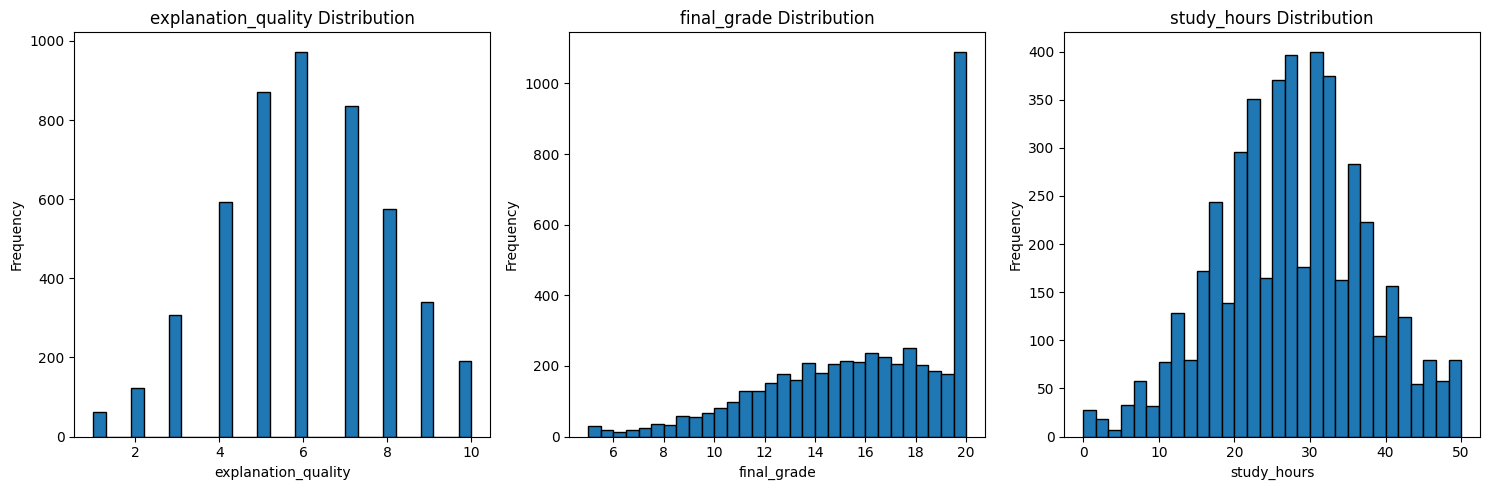

In [21]:
# Select numerical columns
numerical_cols = ['explanation_quality', 'final_grade', 'study_hours']

#cast final grade column to float 
data['final_grade'] = data['final_grade'].astype(float)

# Create subplots
plt.figure(figsize=(15, 5))

for idx, col in enumerate(numerical_cols):
    plt.subplot(1, 3, idx + 1)  # 1 row, 3 columns, plot number idx+1
    plt.hist(data[col], bins=30, edgecolor='black')
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# feature engineering 

why binary encoding ?

In [22]:
# 1. Encode group_work (yes/no --> 1/0)
def encode_group_work(df: pd.DataFrame) -> pd.DataFrame:
    df['Group Study'] = df['Group Study'].map({'oui': 1, 'non': 0})
    return df

In [23]:
encode_group_work(structured_data)

,Autoformation,Note,Study Quality,Absence,Group Study,Alignement with Lecture,Horaire,Class Engagement,Result
0,33,16.32,7,<25%,1,mélange,matin,un petit peu,valide apres rattrapage
1,26,16.00,7,<25%,1,fait parti du cours enseigner par le prof,soir,un petit peu,valide apres rattrapage
2,34,17.88,6,<25%,1,mélange,soir,un petit peu,valide apres rattrapage
3,43,20.00,4,<50%,0,mélange,soir,moyen,valide apres rattrapage
4,25,13.25,5,<25%,1,mélange,matin,moyen,valide apres rattrapage
...,...,...,...,...,...,...,...,...,...
4867,27,16.66,6,<25%,1,exam de la nasa,soir,un petit peu,valide apres rattrapage
4868,29,15.57,8,<1%,1,mélange,matin,un petit peu,valide apres rattrapage
4869,22,12.36,6,>50%,1,mélange,matin,moyen,valide apres rattrapage
4870,50,20.00,4,<1%,0,mélange,matin,un petit peu,valide apres rattrapage


why ordinal encoding 

In [24]:

# 2. Encode absences (<1%, <25%, etc.) as ordered categories
def encode_absences(df: pd.DataFrame) -> pd.DataFrame:
    absence_order = ['<1%', '<25%', '<50%', '>50%']
    ord_encoder = OrdinalEncoder(categories=[absence_order])
    df['Absence'] = ord_encoder.fit_transform(df[['Absence']])
    return df

In [25]:
encode_absences(structured_data)

,Autoformation,Note,Study Quality,Absence,Group Study,Alignement with Lecture,Horaire,Class Engagement,Result
0,33,16.32,7,1.0,1,mélange,matin,un petit peu,valide apres rattrapage
1,26,16.00,7,1.0,1,fait parti du cours enseigner par le prof,soir,un petit peu,valide apres rattrapage
2,34,17.88,6,1.0,1,mélange,soir,un petit peu,valide apres rattrapage
3,43,20.00,4,2.0,0,mélange,soir,moyen,valide apres rattrapage
4,25,13.25,5,1.0,1,mélange,matin,moyen,valide apres rattrapage
...,...,...,...,...,...,...,...,...,...
4867,27,16.66,6,1.0,1,exam de la nasa,soir,un petit peu,valide apres rattrapage
4868,29,15.57,8,0.0,1,mélange,matin,un petit peu,valide apres rattrapage
4869,22,12.36,6,3.0,1,mélange,matin,moyen,valide apres rattrapage
4870,50,20.00,4,0.0,0,mélange,matin,un petit peu,valide apres rattrapage


why binary encoding

In [26]:
# 3. Encode schedule (matin/soir) as binary 0/1
def encode_schedule(df: pd.DataFrame) -> pd.DataFrame:
    df['Horaire'] = df['Horaire'].map({'matin': 0, 'soir': 1})
    return df

In [27]:
encode_schedule(structured_data)

,Autoformation,Note,Study Quality,Absence,Group Study,Alignement with Lecture,Horaire,Class Engagement,Result
0,33,16.32,7,1.0,1,mélange,0,un petit peu,valide apres rattrapage
1,26,16.00,7,1.0,1,fait parti du cours enseigner par le prof,1,un petit peu,valide apres rattrapage
2,34,17.88,6,1.0,1,mélange,1,un petit peu,valide apres rattrapage
3,43,20.00,4,2.0,0,mélange,1,moyen,valide apres rattrapage
4,25,13.25,5,1.0,1,mélange,0,moyen,valide apres rattrapage
...,...,...,...,...,...,...,...,...,...
4867,27,16.66,6,1.0,1,exam de la nasa,1,un petit peu,valide apres rattrapage
4868,29,15.57,8,0.0,1,mélange,0,un petit peu,valide apres rattrapage
4869,22,12.36,6,3.0,1,mélange,0,moyen,valide apres rattrapage
4870,50,20.00,4,0.0,0,mélange,0,un petit peu,valide apres rattrapage


why ordinal encoding

In [28]:
# 4. Encode class participation (un petit peu < moyen < etudiant ideale)
def encode_class_participation(df: pd.DataFrame) -> pd.DataFrame:
    participation_order = ['un petit peu', 'moyen', 'etudiant ideale']
    ord_encoder = OrdinalEncoder(categories=[participation_order])
    df['Class Engagement'] = ord_encoder.fit_transform(df[['Class Engagement']])
    return df

In [29]:
encode_class_participation(structured_data)

,Autoformation,Note,Study Quality,Absence,Group Study,Alignement with Lecture,Horaire,Class Engagement,Result
0,33,16.32,7,1.0,1,mélange,0,0.0,valide apres rattrapage
1,26,16.00,7,1.0,1,fait parti du cours enseigner par le prof,1,0.0,valide apres rattrapage
2,34,17.88,6,1.0,1,mélange,1,0.0,valide apres rattrapage
3,43,20.00,4,2.0,0,mélange,1,1.0,valide apres rattrapage
4,25,13.25,5,1.0,1,mélange,0,1.0,valide apres rattrapage
...,...,...,...,...,...,...,...,...,...
4867,27,16.66,6,1.0,1,exam de la nasa,1,0.0,valide apres rattrapage
4868,29,15.57,8,0.0,1,mélange,0,0.0,valide apres rattrapage
4869,22,12.36,6,3.0,1,mélange,0,1.0,valide apres rattrapage
4870,50,20.00,4,0.0,0,mélange,0,0.0,valide apres rattrapage


why ordinal encoding

In [30]:
def onehot_encode_exam_content(df: pd.DataFrame) -> pd.DataFrame:
    # Ensure clean text (remove extra spaces)
    if df['Alignement with Lecture'].dtype == 'object':
        df['Alignement with Lecture'] = df['Alignement with Lecture'].str.strip()
    
    # Perform One-Hot Encoding
    onehot = pd.get_dummies(
        df['Alignement with Lecture'],
        prefix='Alignement',
        dtype=int,  # ensures 0/1 integers not booleans,
        drop_first=True  # to avoid dummy variable trap
    )
    
    # Drop original and merge one-hot columns
    df = df.drop(columns=['Alignement with Lecture'])
    df = pd.concat([df, onehot], axis=1)
    
    return df


In [31]:
structured_data = onehot_encode_exam_content(structured_data)

In [32]:
structured_data.head(5000)

,Autoformation,Note,Study Quality,Absence,Group Study,Horaire,Class Engagement,Result,Alignement_fait parti du cours enseigner par le prof,Alignement_mélange
0,33,16.32,7,1.0,1,0,0.0,valide apres rattrapage,0,1
1,26,16.00,7,1.0,1,1,0.0,valide apres rattrapage,1,0
2,34,17.88,6,1.0,1,1,0.0,valide apres rattrapage,0,1
3,43,20.00,4,2.0,0,1,1.0,valide apres rattrapage,0,1
4,25,13.25,5,1.0,1,0,1.0,valide apres rattrapage,0,1
...,...,...,...,...,...,...,...,...,...,...
4867,27,16.66,6,1.0,1,1,0.0,valide apres rattrapage,0,0
4868,29,15.57,8,0.0,1,0,0.0,valide apres rattrapage,0,1
4869,22,12.36,6,3.0,1,0,1.0,valide apres rattrapage,0,1
4870,50,20.00,4,0.0,0,0,0.0,valide apres rattrapage,0,1


In [33]:
def encode_target(df: pd.DataFrame) -> pd.DataFrame:
    label_encoder = LabelEncoder()
    df['Result'] = label_encoder.fit_transform(df['Result'])
    return df

In [34]:
encode_target(structured_data)

,Autoformation,Note,Study Quality,Absence,Group Study,Horaire,Class Engagement,Result,Alignement_fait parti du cours enseigner par le prof,Alignement_mélange
0,33,16.32,7,1.0,1,0,0.0,4,0,1
1,26,16.00,7,1.0,1,1,0.0,4,1,0
2,34,17.88,6,1.0,1,1,0.0,4,0,1
3,43,20.00,4,2.0,0,1,1.0,4,0,1
4,25,13.25,5,1.0,1,0,1.0,4,0,1
...,...,...,...,...,...,...,...,...,...,...
4867,27,16.66,6,1.0,1,1,0.0,4,0,0
4868,29,15.57,8,0.0,1,0,0.0,4,0,1
4869,22,12.36,6,3.0,1,0,1.0,4,0,1
4870,50,20.00,4,0.0,0,0,0.0,4,0,1


# Separate features and target


In [35]:
X = structured_data.drop(columns=['Result'])  # Features (everything except the target)
y = structured_data['Result']  # Target variable


In [36]:
print(y)

0       4
1       4
2       4
3       4
4       4
       ..
4867    4
4868    4
4869    4
4870    4
4871    4
Name: Result, Length: 4872, dtype: int64


# Split X and y into training and testing sets


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,      # 30% test, 70% train
    random_state=42,    # random state for reproducibility
    stratify=y          # keep the same distribution of result classes
)

# Let's check the shapes
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)


Training set: (3410, 9) (3410,)
Testing set: (1462, 9) (1462,)


In [38]:
try:
    results
except NameError:
    results = []

print("="*50)
print("Training: Logistic Regression")
print("="*50)

start_train = time.time()
log_reg = LogisticRegression(max_iter=1000)
param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}
grid_log = GridSearchCV(log_reg, param_grid_log_reg, cv=3, n_jobs=-1, scoring='accuracy')
grid_log.fit(X_train, y_train)
best_log = grid_log.best_estimator_
train_duration = round(time.time() - start_train, 2)

start_pred = time.time()
y_pred_log = best_log.predict(X_test)
pred_duration = round(time.time() - start_pred, 2)

acc_log = accuracy_score(y_test, y_pred_log)
print(f"Best Params: {grid_log.best_params_}")
print(f"Accuracy: {acc_log:.4f}")
print(classification_report(y_test, y_pred_log, zero_division=0))

results.append({
    'Model': 'Logistic Regression',
    'Best Params': grid_log.best_params_,
    'Accuracy': acc_log,
    'Training Time (s)': train_duration,
    'Prediction Time (s)': pred_duration
})

Training: Logistic Regression
Best Params: {'C': 10, 'solver': 'lbfgs'}
Accuracy: 0.8427
              precision    recall  f1-score   support

           0       0.44      0.49      0.46        82
           1       0.47      0.31      0.38        58
           2       0.37      0.25      0.30        68
           3       0.86      0.87      0.86       362
           4       0.92      0.94      0.93       892

    accuracy                           0.84      1462
   macro avg       0.61      0.57      0.59      1462
weighted avg       0.83      0.84      0.84      1462



In [39]:
print("="*50)
print("Training: KNN")
print("="*50)

start_train = time.time()
knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
grid_knn = GridSearchCV(knn, param_grid_knn, cv=3, n_jobs=-1, scoring='accuracy')
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
train_duration = round(time.time() - start_train, 2)

start_pred = time.time()
y_pred_knn = best_knn.predict(X_test)
pred_duration = round(time.time() - start_pred, 2)

acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"Best Params: {grid_knn.best_params_}")
print(f"Accuracy: {acc_knn:.4f}")
print(classification_report(y_test, y_pred_knn, zero_division=0))

results.append({
    'Model': 'KNN',
    'Best Params': grid_knn.best_params_,
    'Accuracy': acc_knn,
    'Training Time (s)': train_duration,
    'Prediction Time (s)': pred_duration
})

Training: KNN
Best Params: {'n_neighbors': 3, 'weights': 'distance'}
Accuracy: 0.8598
              precision    recall  f1-score   support

           0       0.83      0.98      0.90        82
           1       0.43      0.22      0.30        58
           2       0.53      0.25      0.34        68
           3       0.85      0.82      0.84       362
           4       0.89      0.95      0.92       892

    accuracy                           0.86      1462
   macro avg       0.71      0.64      0.66      1462
weighted avg       0.84      0.86      0.85      1462



In [40]:
print("="*50)
print("Training: SVM")
print("="*50)

start_train = time.time()
svm = SVC()
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],  # Added 'poly' for polynomial kernel
    'degree': [2, 3, 4]  # Degree of the polynomial kernel
}
grid_svm = GridSearchCV(svm, param_grid_svm, cv=3, n_jobs=-1, scoring='accuracy')
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_
train_duration = round(time.time() - start_train, 2)

start_pred = time.time()
y_pred_svm = best_svm.predict(X_test)
pred_duration = round(time.time() - start_pred, 2)

acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"Best Params: {grid_svm.best_params_}")
print(f"Accuracy: {acc_svm:.4f}")
print(classification_report(y_test, y_pred_svm, zero_division=0))

results.append({
    'Model': 'SVM',
    'Best Params': grid_svm.best_params_,
    'Accuracy': acc_svm,
    'Training Time (s)': train_duration,
    'Prediction Time (s)': pred_duration
})

Training: SVM
Best Params: {'C': 10, 'degree': 2, 'kernel': 'rbf'}
Accuracy: 0.9172
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        82
           1       0.25      0.05      0.09        58
           2       0.48      0.47      0.48        68
           3       0.90      0.97      0.93       362
           4       0.99      0.98      0.98       892

    accuracy                           0.92      1462
   macro avg       0.67      0.69      0.67      1462
weighted avg       0.90      0.92      0.90      1462



In [41]:
print("="*50)
print("Training: Decision Tree")
print("="*50)

# 1. Training + Grid Search
start_train = time.time()
tree = DecisionTreeClassifier()
param_grid_tree = {
    'max_depth': [1,2,3,4,5, 10, 20,50],
    'criterion': ['gini', 'entropy']
}
grid_tree = GridSearchCV(tree, param_grid_tree, cv=3, n_jobs=-1, scoring='accuracy')
grid_tree.fit(X_train, y_train)
best_tree = grid_tree.best_estimator_
train_duration = round(time.time() - start_train, 2)

# 2. Prediction
start_pred = time.time()
y_pred_tree = best_tree.predict(X_test)
pred_duration = round(time.time() - start_pred, 2)

# 3. Evaluation
acc_tree = accuracy_score(y_test, y_pred_tree)
print(f"Best Params: {grid_tree.best_params_}")
print(f"Accuracy: {acc_tree:.4f}")
print(classification_report(y_test, y_pred_tree, zero_division=0))

# 4. Save results
results.append({
    'Model': 'Decision Tree',
    'Best Params': grid_tree.best_params_,
    'Accuracy': acc_tree,
    'Training Time (s)': train_duration,
    'Prediction Time (s)': pred_duration
})

Training: Decision Tree
Best Params: {'criterion': 'entropy', 'max_depth': 10}
Accuracy: 0.9590
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        82
           1       0.49      0.29      0.37        58
           2       0.54      0.72      0.62        68
           3       1.00      1.00      1.00       362
           4       1.00      1.00      1.00       892

    accuracy                           0.96      1462
   macro avg       0.80      0.80      0.80      1462
weighted avg       0.96      0.96      0.96      1462



In [42]:
print("="*50)
print("Training: Random Forest")
print("="*50)

# 1. Training + Grid Search
start_train = time.time()
rf = RandomForestClassifier()
param_grid_rf = {
    'n_estimators': [50,100, 200,300],
    'max_depth': [1,2,3,4,5,20,50,100],
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, n_jobs=-1, scoring='accuracy')
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
train_duration = round(time.time() - start_train, 2)

# 2. Prediction
start_pred = time.time()
y_pred_rf = best_rf.predict(X_test)
pred_duration = round(time.time() - start_pred, 2)

# 3. Evaluation
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Best Params: {grid_rf.best_params_}")
print(f"Accuracy: {acc_rf:.4f}")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# 4. Save results
results.append({
    'Model': 'Random Forest',
    'Best Params': grid_rf.best_params_,
    'Accuracy': acc_rf,
    'Training Time (s)': train_duration,
    'Prediction Time (s)': pred_duration
})

Training: Random Forest
Best Params: {'max_depth': 20, 'n_estimators': 100}
Accuracy: 0.9590
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        82
           1       0.49      0.38      0.43        58
           2       0.56      0.65      0.60        68
           3       1.00      1.00      1.00       362
           4       1.00      1.00      1.00       892

    accuracy                           0.96      1462
   macro avg       0.80      0.81      0.80      1462
weighted avg       0.96      0.96      0.96      1462



In [43]:
print("="*50)
print("Training: LightGBM")
print("="*50)

# 1. Training + Grid Search
start_train = time.time()
lgbm = LGBMClassifier()
param_grid_lgbm = {
    'n_estimators': [50,100, 200,300],
    'learning_rate': [0.05, 0.1]
}
grid_lgbm = GridSearchCV(lgbm, param_grid_lgbm, cv=3, n_jobs=-1, scoring='accuracy')
grid_lgbm.fit(X_train, y_train)
best_lgbm = grid_lgbm.best_estimator_
train_duration = round(time.time() - start_train, 2)

# 2. Prediction
start_pred = time.time()
y_pred_lgbm = best_lgbm.predict(X_test)
pred_duration = round(time.time() - start_pred, 2)

# 3. Evaluation
acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
print(f"Best Params: {grid_lgbm.best_params_}")
print(f"Accuracy: {acc_lgbm:.4f}")
print(classification_report(y_test, y_pred_lgbm, zero_division=0))

# 4. Save results
results.append({
    'Model': 'LightGBM',
    'Best Params': grid_lgbm.best_params_,
    'Accuracy': acc_lgbm,
    'Training Time (s)': train_duration,
    'Prediction Time (s)': pred_duration
})

Training: LightGBM


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 3410, number of used features: 9
[LightGBM] [Info] Start training from score -2.876972
[LightGBM] [Info] Start training from score -3.236628
[LightGBM] [Info] Start training from score -3.065563
[LightGBM] [Info] Start training from score -1.397501
[LightGBM] [Info] Start training from score -0.493383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [44]:
# Create a DataFrame from the collected results
results_df = pd.DataFrame(results)

# Sort the models by their Accuracy (optional)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

# Display the table
print("\n\nFinal Model Performance Summary:\n")
print(results_df.to_string(index=False))



Final Model Performance Summary:

              Model                                Best Params  Accuracy  Training Time (s)  Prediction Time (s)
      Random Forest     {'max_depth': 20, 'n_estimators': 100}  0.958960              26.24                 0.02
      Decision Tree  {'criterion': 'entropy', 'max_depth': 10}  0.958960               0.33                 0.00
           LightGBM {'learning_rate': 0.1, 'n_estimators': 50}  0.957592              19.87                 0.02
                SVM    {'C': 10, 'degree': 2, 'kernel': 'rbf'}  0.917237              38.45                 0.44
                KNN  {'n_neighbors': 3, 'weights': 'distance'}  0.859781               0.62                 0.02
Logistic Regression               {'C': 10, 'solver': 'lbfgs'}  0.842681               9.97                 0.00


In [45]:
import time
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Initialize results
results = []

# Define models and parameters
models_and_params = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {
        'C': [0.01, 0.1, 1, 10, 50],
        'solver': ['lbfgs', 'liblinear']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': list(range(3, 11)),
        'weights': ['uniform', 'distance']
    }),
    'SVM': (SVC(), {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [2, 3, 4]
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [3, 5, 10, 20],
        'criterion': ['gini', 'entropy']
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [5, 10, 20, 30]
    }),
    'LightGBM': (LGBMClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1]
    }),
    
    
}

# Train models
for model_name, (model, param_dist) in models_and_params.items():
    print("="*50)
    print(f"Training: {model_name}")
    print("="*50)
    
    # 1. Train
    start_train = time.time()
    random_search = RandomizedSearchCV(
        model, 
        param_distributions=param_dist,
        n_iter=20,           # Try 10 random combinations
        cv=3, 
        n_jobs=-1, 
        scoring='accuracy',
        random_state=42
    )
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    train_duration = round(time.time() - start_train, 2)
    
    # 2. Predict
    start_pred = time.time()
    y_pred = best_model.predict(X_test)
    pred_duration = round(time.time() - start_pred, 2)
    
    # 3. Evaluate
    acc = accuracy_score(y_test, y_pred)
    print(f"Best Params: {random_search.best_params_}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # 4. Save results
    results.append({
        'Model': model_name,
        'Best Params': random_search.best_params_,
        'Accuracy': acc,
        'Training Time (s)': train_duration,
        'Prediction Time (s)': pred_duration
    })

# Final Table
results_df = pd.DataFrame(results)
print("\n\nFinal Model Performance Summary:")
print(results_df.sort_values(by='Accuracy', ascending=False))


Training: Logistic Regression


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params: {'solver': 'lbfgs', 'C': 10}
Accuracy: 0.8427
              precision    recall  f1-score   support

           0       0.44      0.49      0.46        82
           1       0.47      0.31      0.38        58
           2       0.37      0.25      0.30        68
           3       0.86      0.87      0.86       362
           4       0.92      0.94      0.93       892

    accuracy                           0.84      1462
   macro avg       0.61      0.57      0.59      1462
weighted avg       0.83      0.84      0.84      1462

Training: KNN


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params: {'weights': 'distance', 'n_neighbors': 8}
Accuracy: 0.8735
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        82
           1       0.50      0.14      0.22        58
           2       0.60      0.22      0.32        68
           3       0.89      0.84      0.86       362
           4       0.89      0.98      0.93       892

    accuracy                           0.87      1462
   macro avg       0.74      0.63      0.64      1462
weighted avg       0.85      0.87      0.85      1462

Training: SVM
Best Params: {'kernel': 'rbf', 'degree': 3, 'C': 100}
Accuracy: 0.9275
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        82
           1       0.35      0.31      0.33        58
           2       0.51      0.43      0.46        68
           3       0.95      0.97      0.96       362
           4       0.99      0.98      0.99       892

    accuracy                

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params: {'n_estimators': 100, 'max_depth': 10}
Accuracy: 0.9596
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        82
           1       0.51      0.36      0.42        58
           2       0.56      0.68      0.61        68
           3       1.00      1.00      1.00       362
           4       1.00      1.00      1.00       892

    accuracy                           0.96      1462
   macro avg       0.81      0.81      0.80      1462
weighted avg       0.96      0.96      0.96      1462

Training: LightGBM


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 3410, number of used features: 9
[LightGBM] [Info] Start training from score -2.876972
[LightGBM] [Info] Start training from score -3.236628
[LightGBM] [Info] Start training from score -3.065563
[LightGBM] [Info] Start training from score -1.397501
[LightGBM] [Info] Start training from score -0.493383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
